In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

In [62]:
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.3.0-posix-seh-rt_v5-rev0\\mingw64\\bin'

os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [63]:
import xgboost as xgb

# Load the datasets 

In [4]:
df = pd.read_csv("train.csv")
df_backup= df
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [5]:
test = pd.read_csv("test.csv")
test.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,36306,Male,80.0,0,0,Yes,Private,Urban,83.84,21.1,formerly smoked
1,61829,Female,74.0,0,1,Yes,Self-employed,Rural,179.50,26.0,formerly smoked
2,14152,Female,14.0,0,0,No,children,Rural,95.16,21.2,NaN
3,12997,Male,28.0,0,0,No,Private,Urban,94.76,23.4,NaN
4,40801,Female,63.0,0,0,Yes,Govt_job,Rural,83.57,27.6,never smoked


In [6]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,41938.000000,43400.000000
mean,36326.142350,42.217894,0.093571,0.047512,104.482750,28.605038,0.018041
std,21072.134879,22.519649,0.291235,0.212733,43.111751,7.770020,0.133103
min,1.000000,0.080000,0.000000,0.000000,55.000000,10.100000,0.000000
25%,18038.500000,24.000000,0.000000,0.000000,77.540000,23.200000,0.000000
50%,36351.500000,44.000000,0.000000,0.000000,91.580000,27.700000,0.000000
75%,54514.250000,60.000000,0.000000,0.000000,112.070000,32.900000,0.000000
max,72943.000000,82.000000,1.000000,1.000000,291.050000,97.600000,1.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
id                   43400 non-null int64
gender               43400 non-null object
age                  43400 non-null float64
hypertension         43400 non-null int64
heart_disease        43400 non-null int64
ever_married         43400 non-null object
work_type            43400 non-null object
Residence_type       43400 non-null object
avg_glucose_level    43400 non-null float64
bmi                  41938 non-null float64
smoking_status       30108 non-null object
stroke               43400 non-null int64
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


We see that bmi and smoking status, which can be significant predictors, is not available for a lot of cases. We will try to impute values for both of them. For BMI, we can impute the values using mean BMI for the age and gender subgroup to which that row belongs.

In [8]:
df.drop("id", axis =1, inplace=True)

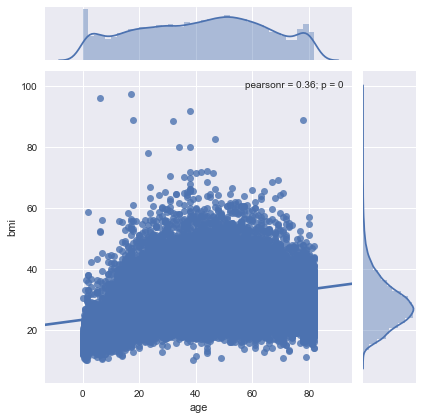

In [9]:
sns.jointplot(x = 'age', y='bmi', data=df, kind='reg');

In [10]:
print(df.age.max(),",", test.age.max())

82.0 , 82.0


In [11]:
age_bins = [ 0, 10, 20, 30, 40, 50, 60, 70, 100]
labels = ['0-9','10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']
df['age_group'] = pd.cut(df.age, age_bins, labels=labels, right=False, include_lowest=True)

In [12]:
df.age_group.head()

0      0-9
1    50-59
2      0-9
3      70+
4    10-19
Name: age_group, dtype: category
Categories (8, object): [0-9 < 10-19 < 20-29 < 30-39 < 40-49 < 50-59 < 60-69 < 70+]

In [13]:
group_bmi_mean = df['bmi'].groupby(df.age_group).mean()
group_bmi_median = df['bmi'].groupby(df.age_group).median()

In [14]:
group_bmi_mean

age_group
0-9      18.701139
10-19    24.530727
20-29    28.337304
30-39    30.623657
40-49    31.190610
50-59    31.391989
60-69    31.246874
70+      28.947642
Name: bmi, dtype: float64

In [15]:
group_bmi_median

age_group
0-9      18.0
10-19    23.3
20-29    26.8
30-39    29.2
40-49    30.0
50-59    30.3
60-69    30.2
70+      28.2
Name: bmi, dtype: float64

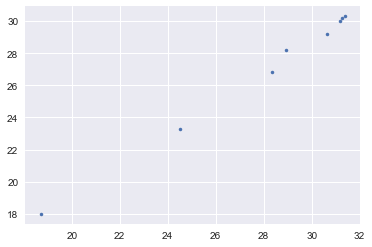

In [16]:
plt.plot(group_bmi_mean, group_bmi_median, '.');

In [17]:
ind = df[df.bmi.isnull()].bmi.index
for i in ind:
    df.loc[df.index ==i,'bmi'] = group_bmi_mean[df.iloc[i,].age_group]

In [18]:
df.isnull().sum()

gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                      0
smoking_status       13292
stroke                   0
age_group                0
dtype: int64

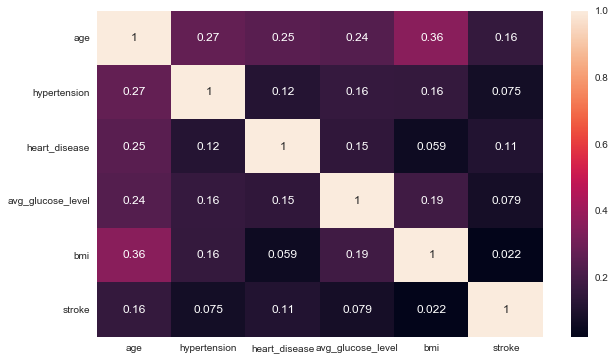

In [19]:
corr = df.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)

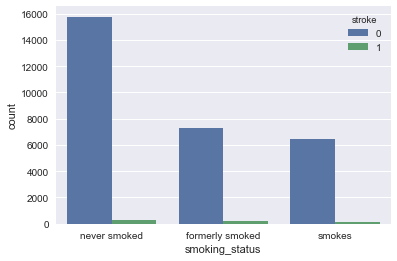

In [20]:
sns.countplot(x='smoking_status', hue='stroke', data=df)

Since the missing values in smoking status column are approximately one third of the total, we can make the missing values as a separate category. Let's say we call it "Anything".

In [21]:
df.smoking_status.replace(to_replace= np.nan, value="Anything", inplace=True)

In [22]:
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
age_group            0
dtype: int64

Lets' do the similar imputation to the test dataset

In [23]:
test.isnull().sum()

id                      0
gender                  0
age                     0
hypertension            0
heart_disease           0
ever_married            0
work_type               0
Residence_type          0
avg_glucose_level       0
bmi                   591
smoking_status       5751
dtype: int64

In [24]:
test['age_group'] = pd.cut(test.age, bins=age_bins, labels=labels, include_lowest=True,right=False)

In [25]:
test_bmi_age_group = test.bmi.groupby(by=test.age_group).mean()

In [26]:
group_bmi_mean-test_bmi_age_group

age_group
0-9      0.033968
10-19    0.001810
20-29    0.026280
30-39   -0.160794
40-49    0.162174
50-59    0.220978
60-69   -0.021640
70+     -0.111114
Name: bmi, dtype: float64

There isn't much difference between the mean bmi's for respective age groups in test and train dataset.

In [27]:
ids = test[test.bmi.isnull()].index
for i in ids:
    test.loc[test.index ==i, 'bmi'] = test_bmi_age_group[test.iloc[i].age_group]

In [28]:
test.smoking_status.replace(to_replace=np.nan, value="Anything", inplace=True)

In [29]:
test.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
age_group            0
dtype: int64

In [30]:
test.drop('id', axis=1, inplace=True)

In [31]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group
0,Male,3.0,0,0,No,children,Rural,95.12,18.0,Anything,0,0-9
1,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0,50-59
2,Female,8.0,0,0,No,Private,Urban,110.89,17.6,Anything,0,0-9
3,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0,70+
4,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,Anything,0,10-19


In [32]:
df= pd.get_dummies(df, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 
                                'smoking_status','age_group'], drop_first=True)

test= pd.get_dummies(test, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 
                                'smoking_status','age_group'], drop_first=True)

In [33]:
test.drop('age', axis=1, inplace=True)
df.drop('age', axis=1, inplace=True)

In [34]:
df.head()

,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,...,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,age_group_10-19,age_group_20-29,age_group_30-39,age_group_40-49,age_group_50-59,age_group_60-69,age_group_70+
0,0,0,95.12,18.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,87.96,39.2,0,1,0,1,0,1,...,0,1,0,0,0,0,0,1,0,0
2,0,0,110.89,17.6,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,69.04,35.9,0,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,1
4,0,0,161.28,19.1,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


#### Checking class imbalance

In [35]:
(df.stroke.sum()/len(df)) *100

1.804147465437788

We see that our problem of stroke classification is highly imbalanced which was expected for such a problem.

Now, let's do some exploratory analysis of the training data.

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print ("BEST", gs.best_params_, gs.best_score_)
    best = gs.best_estimator_
    return best
def do_classify(clf, parameters, Xtrain, Xtest, ytrain, ytest, score_func=None, n_folds=5, n_jobs=1):
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print ("############# based on standard predict ################")
    print ("Accuracy on training data: %0.2f" % (training_accuracy))
    print ("Accuracy on test data:     %0.2f" % (test_accuracy))
    print (confusion_matrix(ytest, clf.predict(Xtest)))
    print ("########################################################")
    return clf, Xtrain, ytrain, Xtest, ytest

In [79]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [38]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in range(0, fpr.shape[0],labe):
        #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

In [39]:
df_cols = list(df.columns)
df_cols.remove('stroke')

In [40]:
X = df[df_cols]
y = df['stroke'].values
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=0)

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
clflog = LogisticRegression()
parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
clflog, Xtrain, ytrain, Xtest, ytest = do_classify(clflog, parameters, Xtrain, Xtest, ytrain, ytest, score_func='roc_auc')

BEST {'C': 10000} 0.846039601725
############# based on standard predict ################
Accuracy on training data: 0.98
Accuracy on test data:     0.98
[[8547    0]
 [ 133    0]]
########################################################


In [55]:
clflog.predict(Xtest).sum()

0

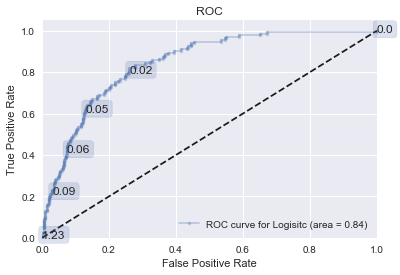

In [56]:
make_roc("Logisitc", clflog, ytest, Xtest, None, labe=50)

As expected, logisitc regressioin performed very poorly due to class imbalance.

In [57]:
from sklearn.naive_bayes import GaussianNB
clfgnb = GaussianNB()
clfgnb, Xtrain, ytrain, Xtest, ytest=do_classify(clfgnb, None, Xtrain, Xtest, ytrain, ytest, score_func='roc_auc')

############# based on standard predict ################
Accuracy on training data: 0.46
Accuracy on test data:     0.46
[[3847 4700]
 [   5  128]]
########################################################


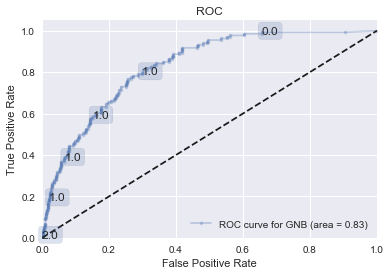

In [58]:
make_roc("GNB", clfgnb, ytest, Xtest, None, labe=50)

In [46]:
from sklearn.ensemble import AdaBoostClassifier

In [59]:
clfada = AdaBoostClassifier(n_estimators=100, learning_rate=0.01, random_state=0)
clfada, Xtrain, ytrain, Xtest, ytest=do_classify(clfada, None, Xtrain, Xtest, ytrain, ytest, score_func='roc_auc')

############# based on standard predict ################
Accuracy on training data: 0.98
Accuracy on test data:     0.98
[[8547    0]
 [ 133    0]]
########################################################


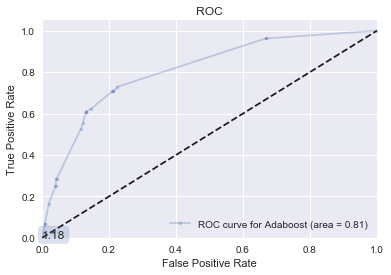

In [60]:
make_roc("Adaboost", clfada, ytest, Xtest, None, labe=50)

Now, we will try XGBoost

In [64]:
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
xgb_model = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'roc_auc', cv = 5, n_jobs = -1) 

In [66]:
xgb_model.fit(Xtrain, ytrain)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [67]:
xgb_model.cv_results_

C:\Users\Sukant\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Sukant\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Sukant\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Sukant\Anaconda3\lib\site-packages\sklearn\ut

{'mean_fit_time': array([ 18.93078923,  20.44853168,  23.55184412,  32.98137984,
         34.33685684,  33.36334891,  46.86222062,  46.73665619,  40.58668556]),
 'mean_score_time': array([ 0.2564815 ,  0.24819779,  0.29488173,  0.61848016,  0.45170074,
         0.50026789,  0.74848957,  0.6831542 ,  0.55270357]),
 'mean_test_score': array([ 0.81577657,  0.81844257,  0.82022251,  0.77992346,  0.78101477,
         0.78802093,  0.76631912,  0.76353209,  0.76873349]),
 'mean_train_score': array([ 0.96453979,  0.95540576,  0.94898585,  0.99961114,  0.99605107,
         0.99081081,  1.        ,  0.99996801,  0.99931338]),
 'param_max_depth': masked_array(data = [3 3 3 5 5 5 7 7 7],
              mask = [False False False False False False False False False],
        fill_value = ?),
 'param_min_child_weight': masked_array(data = [1 3 5 1 3 5 1 3 5],
              mask = [False False False False False False False False False],
        fill_value = ?),
 'params': [{'max_depth': 3, 'min_child_w

In [68]:
xgb_model.grid_scores_

C:\Users\Sukant\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.81578, std: 0.01465, params: {'max_depth': 3, 'min_child_weight': 1},
 mean: 0.81844, std: 0.01415, params: {'max_depth': 3, 'min_child_weight': 3},
 mean: 0.82022, std: 0.01132, params: {'max_depth': 3, 'min_child_weight': 5},
 mean: 0.77992, std: 0.01191, params: {'max_depth': 5, 'min_child_weight': 1},
 mean: 0.78101, std: 0.01450, params: {'max_depth': 5, 'min_child_weight': 3},
 mean: 0.78802, std: 0.01228, params: {'max_depth': 5, 'min_child_weight': 5},
 mean: 0.76632, std: 0.01468, params: {'max_depth': 7, 'min_child_weight': 1},
 mean: 0.76353, std: 0.01129, params: {'max_depth': 7, 'min_child_weight': 3},
 mean: 0.76873, std: 0.00949, params: {'max_depth': 7, 'min_child_weight': 5}]

In [70]:
cv_params = {'learning_rate': [0.1, 0.01], 'subsample': [0.7,0.8,0.9]}
ind_params = {'n_estimators': 1000, 'seed':0, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth': 3, 'min_child_weight': 5}


xgb_model2 = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'roc_auc', cv = 5, n_jobs = -1)
xgb_model2.fit(Xtrain, ytrain)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=5, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.01], 'subsample': [0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [71]:
xgb_model2.grid_scores_

C:\Users\Sukant\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.82031, std: 0.01315, params: {'learning_rate': 0.1, 'subsample': 0.7},
 mean: 0.82022, std: 0.01132, params: {'learning_rate': 0.1, 'subsample': 0.8},
 mean: 0.82186, std: 0.01306, params: {'learning_rate': 0.1, 'subsample': 0.9},
 mean: 0.85047, std: 0.01400, params: {'learning_rate': 0.01, 'subsample': 0.7},
 mean: 0.85079, std: 0.01371, params: {'learning_rate': 0.01, 'subsample': 0.8},
 mean: 0.85149, std: 0.01355, params: {'learning_rate': 0.01, 'subsample': 0.9}]

In [101]:
cv_params = {'learning_rate': [0.0001, 0.001, 0.01], 'subsample': [0.8,0.9]}
ind_params = {'n_estimators': 1000, 'seed':0, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth': 3, 'min_child_weight': 5}


xgb_model3 = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'roc_auc', cv = 5, n_jobs = -1)
xgb_model3.fit(Xtrain, ytrain)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=5, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.0001, 0.001, 0.01], 'subsample': [0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [103]:
xgb_model3.grid_scores_

C:\Users\Sukant\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.83629, std: 0.01874, params: {'learning_rate': 0.0001, 'subsample': 0.8},
 mean: 0.83668, std: 0.01809, params: {'learning_rate': 0.0001, 'subsample': 0.9},
 mean: 0.84115, std: 0.01789, params: {'learning_rate': 0.001, 'subsample': 0.8},
 mean: 0.84126, std: 0.01725, params: {'learning_rate': 0.001, 'subsample': 0.9},
 mean: 0.85079, std: 0.01371, params: {'learning_rate': 0.01, 'subsample': 0.8},
 mean: 0.85149, std: 0.01355, params: {'learning_rate': 0.01, 'subsample': 0.9}]

Best Params: Learning rate: 0.01, Subsample: 0.9, max_depth: 3, min_child_weight: 5

In [72]:
xgdmat = xgb.DMatrix(Xtrain, ytrain)

In [77]:
our_params = {'eta': 0.01, 'seed':0, 'subsample': 0.9, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':5} 
# Grid Search CV optimized settings

cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 3000, nfold = 5,
                metrics = ['auc'], # Make sure you enter metrics inside a list or you may encounter issues!
                early_stopping_rounds = 50) # Look for early stopping that minimizes error

In [78]:
cv_xgb.tail(5)

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
961,0.852004,0.016709,0.876767,0.004044
962,0.852013,0.016713,0.876791,0.004063
963,0.852011,0.016725,0.876821,0.004055
964,0.852020,0.016749,0.876853,0.004029
965,0.852021,0.016746,0.876880,0.004027


In [80]:
our_params = {'eta': 0.01, 'seed':0, 'subsample': 0.9, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':5} 

final_gb = xgb.train(our_params, xgdmat, num_boost_round = 965)

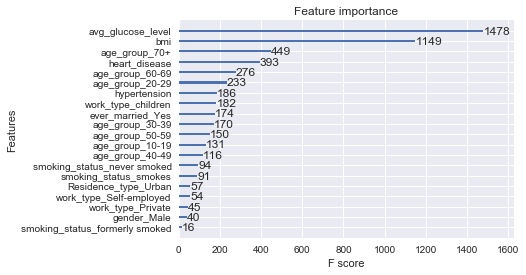

In [81]:
xgb.plot_importance(final_gb)

Getting auc_score for xtest data

In [82]:
testdmat = xgb.DMatrix(Xtest)

In [83]:
y_pred = final_gb.predict(testdmat)

In [84]:
y_pred[:10]

array([ 0.05668844,  0.01621949,  0.00109975,  0.00185913,  0.00193613,
        0.00466664,  0.01830433,  0.02560793,  0.00201595,  0.07198489], dtype=float32)

In [85]:
roc_auc_score(y_true=ytest, y_score=y_pred)

0.85240787120486372

Lets train the XGBoost on the entire training dataset

In [86]:
xgdmat_train = xgb.DMatrix(X, y)

In [87]:
our_params = {'eta': 0.01, 'seed':0, 'subsample': 0.9, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':5} 

final_xgb_model = xgb.train(our_params, xgdmat_train, num_boost_round = 965)

In [92]:
xgdmat_test = xgb.DMatrix(test)

In [94]:
y_test = final_xgb_model.predict(xgdmat_test)

In [97]:
y_test[:10]

array([ 0.04945371,  0.10819553,  0.00050393,  0.00069353,  0.01720602,
        0.03377123,  0.00652705,  0.00684349,  0.06033618,  0.05569892], dtype=float32)

In [98]:
write = pd.DataFrame(y_test)

In [100]:
write.to_csv("XGBoost.csv")